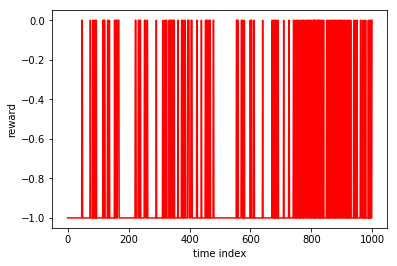

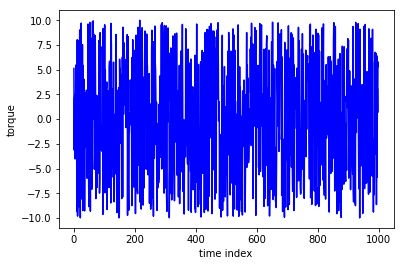

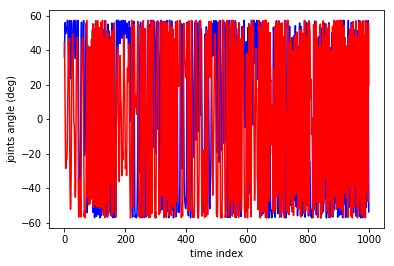

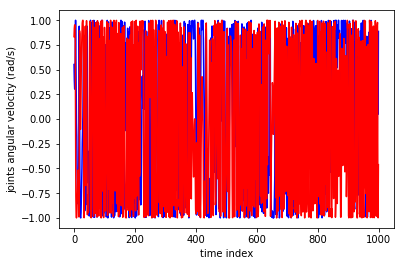

In [2]:
"""classic Acrobot task"""
from gym import core, spaces
from gym.utils import seeding
import numpy as np
from numpy import sin, cos, pi
import matplotlib.pyplot as plt
# adapted from the example given on Gym documentation
class AcrobotEnv(core.Env):

    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second' : 15
    }

    dt = .2

    LINK_LENGTH_1 = 1.  # [m]
    LINK_LENGTH_2 = 1.  # [m]
    LINK_MASS_1 = 1.  #: [kg] mass of link 1
    LINK_MASS_2 = 1.  #: [kg] mass of link 2
    LINK_COM_POS_1 = 0.5  #: [m] position of the center of mass of link 1
    LINK_COM_POS_2 = 0.5  #: [m] position of the center of mass of link 2
    LINK_MOI = 1.  #: moments of inertia for both links

    MAX_VEL_1 = 4 * np.pi
    MAX_VEL_2 = 9 * np.pi

    AVAIL_TORQUE = [-1., 0., +1]

    torque_noise_max = 0.

    book_or_nips = "book"
    action_arrow = None
    domain_fig = None
    actions_num = 3

    def __init__(self):
        self.viewer = None
        high = np.array([1.0, 1.0, 1.0, 1.0, self.MAX_VEL_1, self.MAX_VEL_2])
        low = -high
        self.observation_space = spaces.Box(low=low, high=high,  dtype=np.float32)
        h = np.array([10.0])
        l = np.array([-10.0])
        self.action_space = spaces.Box(low=l, high=h,  dtype=np.float32)
        self.state = None
        self.seed()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        self.state = self.np_random.uniform(low=-1, high=1, size=(4,))
        return self._get_ob()

    def step(self, a):
        s = self.state
        torque = a

        # Add noise to the force action
        if self.torque_noise_max > 0:
            torque += self.np_random.uniform(-self.torque_noise_max, self.torque_noise_max)

        # Now, augment the state with our force action so it can be passed to
        # _dsdt
        s_augmented = np.append(s, torque)

        ns = rk4(self._dsdt, s_augmented, [0, self.dt])
        # only care about final timestep of integration returned by integrator
        ns = ns[-1]
        ns = ns[:4]  # omit action
        # ODEINT IS TOO SLOW!
        # ns_continuous = integrate.odeint(self._dsdt, self.s_continuous, [0, self.dt])
        # self.s_continuous = ns_continuous[-1] # We only care about the state
        # at the ''final timestep'', self.dt

        ns[0] = wrap(ns[0], -pi, pi)
        ns[1] = wrap(ns[1], -pi, pi)
        ns[2] = bound(ns[2], -self.MAX_VEL_1, self.MAX_VEL_1)
        ns[3] = bound(ns[3], -self.MAX_VEL_2, self.MAX_VEL_2)
        self.state = ns
        terminal = self._terminal()
        reward = -1. if not terminal else 0.
        return (self._get_ob(), reward, terminal, {})

    def _get_ob(self):
        s = self.state
        return np.array([cos(s[0]), np.sin(s[0]), cos(s[1]), sin(s[1]), s[2], s[3]])

    def _terminal(self):
        s = self.state
        return bool(-np.cos(s[0]) - np.cos(s[1] + s[0]) > 1.)

    def _dsdt(self, s_augmented, t):
        m1 = self.LINK_MASS_1
        m2 = self.LINK_MASS_2
        l1 = self.LINK_LENGTH_1
        lc1 = self.LINK_COM_POS_1
        lc2 = self.LINK_COM_POS_2
        I1 = self.LINK_MOI
        I2 = self.LINK_MOI
        g = 9.8
        a = s_augmented[-1]
        s = s_augmented[:-1]
        theta1 = s[0]
        theta2 = s[1]
        dtheta1 = s[2]
        dtheta2 = s[3]
        d1 = m1 * lc1 ** 2 + m2 * \
            (l1 ** 2 + lc2 ** 2 + 2 * l1 * lc2 * np.cos(theta2)) + I1 + I2
        d2 = m2 * (lc2 ** 2 + l1 * lc2 * np.cos(theta2)) + I2
        phi2 = m2 * lc2 * g * np.cos(theta1 + theta2 - np.pi / 2.)
        phi1 = - m2 * l1 * lc2 * dtheta2 ** 2 * np.sin(theta2) \
               - 2 * m2 * l1 * lc2 * dtheta2 * dtheta1 * np.sin(theta2)  \
            + (m1 * lc1 + m2 * l1) * g * np.cos(theta1 - np.pi / 2) + phi2
        ddtheta2 = (a + d2 / d1 * phi1 - m2 * l1 * lc2 * dtheta1 ** 2 * np.sin(theta2) - phi2) \
                / (m2 * lc2 ** 2 + I2 - d2 ** 2 / d1)
        ddtheta1 = -(d2 * ddtheta2 + phi1) / d1
        return (dtheta1, dtheta2, ddtheta1, ddtheta2, 0.)

    def render(self, mode='human'):
        from gym.envs.classic_control import rendering

        s = self.state

        if self.viewer is None:
            self.viewer = rendering.Viewer(500,500)
            self.viewer.set_bounds(-2.2,2.2,-2.2,2.2)

        if s is None: return None

        p1 = [-self.LINK_LENGTH_1 *
              np.cos(s[0]), self.LINK_LENGTH_1 * np.sin(s[0])]

        p2 = [p1[0] - self.LINK_LENGTH_2 * np.cos(s[0] + s[1]),
              p1[1] + self.LINK_LENGTH_2 * np.sin(s[0] + s[1])]

        xys = np.array([[0,0], p1, p2])[:,::-1]
        thetas = [s[0]-np.pi/2, s[0]+s[1]-np.pi/2]

        self.viewer.draw_line((-2.2, 1), (2.2, 1))
        for ((x,y),th) in zip(xys, thetas):
            l,r,t,b = 0, 1, .1, -.1
            jtransform = rendering.Transform(rotation=th, translation=(x,y))
            link = self.viewer.draw_polygon([(l,b), (l,t), (r,t), (r,b)])
            link.add_attr(jtransform)
            link.set_color(0,.8, .8)
            circ = self.viewer.draw_circle(.1)
            circ.set_color(.8, .8, 0)
            circ.add_attr(jtransform)

        return self.viewer.render(return_rgb_array = mode=='rgb_array')

    def close(self):
        if self.viewer: self.viewer.close()

def wrap(x, m, M):
    
    diff = M - m
    while x > M:
        x = x - diff
    while x < m:
        x = x + diff
    return x

def bound(x, m, M=None):
    
    if M is None:
        M = m[1]
        m = m[0]
    # bound x between min (m) and Max (M)
    return min(max(x, m), M)


def rk4(derivs, y0, t, *args, **kwargs):
   
    try:
        Ny = len(y0)
    except TypeError:
        yout = np.zeros((len(t),), np.float_)
    else:
        yout = np.zeros((len(t), Ny), np.float_)

    yout[0] = y0


    for i in np.arange(len(t) - 1):

        thist = t[i]
        dt = t[i + 1] - thist
        dt2 = dt / 2.0
        y0 = yout[i]

        k1 = np.asarray(derivs(y0, thist, *args, **kwargs))
        k2 = np.asarray(derivs(y0 + dt2 * k1, thist + dt2, *args, **kwargs))
        k3 = np.asarray(derivs(y0 + dt2 * k2, thist + dt2, *args, **kwargs))
        k4 = np.asarray(derivs(y0 + dt * k3, thist + dt, *args, **kwargs))
        yout[i + 1] = y0 + dt / 6.0 * (k1 + 2 * k2 + 2 * k3 + k4)
    return yout

env = AcrobotEnv()
ep = 1
limit_t = 1000

reward_vector = np.zeros(limit_t)
theta1 = np.zeros(limit_t)
theta2 = np.zeros(limit_t)
theta1_dot = np.zeros(limit_t)
theta2_dot = np.zeros(limit_t)
action_vector = np.zeros(limit_t)
T = np.zeros(limit_t)

for i in range(ep):
    obs = env.reset()
    for t in range(limit_t):
        env.render()
        action = env.action_space.sample()
        obs, reward, term, x = env.step(action)

        reward_vector[t] = reward
        action_vector[t] = action
        theta1[t] = (180/pi) * obs[0]
        theta2[t] = (180/pi) * obs[1]
        theta1_dot[t] = obs[2]
        theta2_dot[t] = obs[3]
        T[t] = t
    env.close()

plt.plot(T, reward_vector, 'r')
plt.ylabel('reward')
plt.xlabel('time index')
plt.show()

plt.plot(T, action_vector, 'b')
plt.ylabel('torque')
plt.xlabel('time index')
plt.show()


plt.plot(T, theta1, 'b')
plt.plot(T, theta2, 'r')
plt.ylabel('joints angle (deg)')
plt.xlabel('time index')
plt.show()

plt.plot(T, theta1_dot, 'b')
plt.plot(T, theta2_dot, 'r')
plt.ylabel('joints angular velocity (rad/s)')
plt.xlabel('time index')
plt.show()